References: https://blog.paperspace.com/pre-trained-word-embeddings-natural-language-processing/

In [1]:
import re #Regex library for cleaning the tweets and removing any punctuations as hashtags are quite common in tweets which are not of much use
import string  # For performing operations on strings
from nltk.corpus import stopwords # To remove any unnecessary qords
from nltk.stem import PorterStemmer # To get the root word
from nltk.tokenize import TweetTokenizer # To break the sentences into words
import numpy as np # For Mathematical computations and array operations
import pandas as pd  #Perform operations on dataset

In [2]:
df=pd.read_csv('deforestation_sentiment_train.csv')

In [3]:
df.shape

(939, 20)

In [4]:
df.head()

,Unnamed: 0,id,text,user_name,user_description,user_location,user_following,user_followers,tweets_by_user,user_created_at,tweet_created,retweets,likes,hashtags,media,search_term,emojis,sentiments_list,revised_sentiment,distillbert_valence
0,253291,1359216214875262980,three palm oil firms were responsible for a qu...,hoteldealphuket,Phuket Hotel Deals offers Phuket property for ...,Phuket,53,288,63131,2013-10-23 01:50:59,2021-02-09 19:02:53,0,0,"[{'text': 'animal_rehabilitation', 'indices': ...",http://pbs.twimg.com/media/Etzn8WuXIAAZ2ju.jpg,deforestation -filter:retweets,NaN,NaN,negative,-0.992038
1,253283,1359691122985947137,despicable #brazil govt using #pandemic as cov...,PhelimKine,Senior Director Asia @StandMighty @TeamWaxman;...,Asia Pacific,1326,19024,53843,2011-09-16 07:06:02,2021-02-11 02:30:00,0,2,"[{'text': 'Brazil', 'indices': [12, 19]}, {'te...",http://pbs.twimg.com/media/Et4nD6zXMAMTg2V.jpg,deforestation -filter:retweets,NaN,NaN,negative,-0.997723
2,253280,1359697180987183105,🌳🍂🌳impacto humano no #desmatamento / \nhuman i...,isis_0726,☮⏳🌍🌎🌏O erro da ética tem sido a crença de que ...,NaN,115,31,3724,2019-10-27 21:15:12,2021-02-11 02:54:04,0,0,"[{'text': 'desmatamento', 'indices': [21, 34]}...",http://pbs.twimg.com/media/Et6dYS4WQAAoNul.jpg,deforestation -filter:retweets,"{'🌳', '❌', '🍂'}",{'neutral'},negative,-0.973575
3,253268,1359718063994667009,deforestation will be the end of the human rac...,AmanzWillieONE,"Sincerity, Awards winner, Crusading Climate an...",Africa.,889,627,3357,2018-11-11 03:14:22,2021-02-11 04:17:03,1,2,[],http://pbs.twimg.com/media/Et6wX0HUYAUrGlg.jpg,deforestation -filter:retweets,NaN,NaN,negative,-0.963673
4,253260,1359734007731269632,@_wrong_guy_ @zerohedge no other codes nowdays...,GordonGecko3,Gold/Silver/Oil/Uranium-Bug\nhttps://t.co/AZNz...,Worldwide,896,242,9518,2011-08-13 20:41:04,2021-02-11 05:20:24,0,1,[],http://pbs.twimg.com/tweet_video_thumb/Et6-3nx...,deforestation -filter:retweets,{'😉'},{'positive'},negative,-0.995930


In [5]:
df["sentiments_list"].value_counts()

{'neutral'}                            128
{'positive'}                            19
{'neutral', 'positive'}                 17
{'neutral', 'negative'}                  9
{'positive', 'neutral'}                  9
{'negative'}                             8
{'positive', 'negative'}                 2
{'neutral', 'negative', 'positive'}      2
Name: sentiments_list, dtype: int64

In [6]:
# delete row where sentiment has both positive and negative as not possible to derive a conclusion from such tweet
indexAge = df[df["sentiments_list"]=="{'positive', 'negative'}" ].index
df.drop(indexAge , inplace=True)

In [7]:
df["sentiments_list"].value_counts()

{'neutral'}                            128
{'positive'}                            19
{'neutral', 'positive'}                 17
{'neutral', 'negative'}                  9
{'positive', 'neutral'}                  9
{'negative'}                             8
{'neutral', 'negative', 'positive'}      2
Name: sentiments_list, dtype: int64

### Positive Sentiment is labelled as 1 and negative is labelled as 0

In [8]:
for index,row in df.iterrows():
  try:
    if "positive" in row["sentiments_list"]:
      df.at[index, 'sentiment'] = 1
    else:
      df.at[index, 'sentiment'] = 0
  except:  # For columns where there are nan values this step will add the sentiment as 0
    df.at[index, 'sentiment'] = 0

In [9]:
df["sentiment"].value_counts()

0.0    890
1.0     47
Name: sentiment, dtype: int64

In [10]:
df.isnull().sum()  # No text is missing

Unnamed: 0               0
id                       0
text                     0
user_name                0
user_description        38
user_location          181
user_following           0
user_followers           0
tweets_by_user           0
user_created_at          0
tweet_created            0
retweets                 0
likes                    0
hashtags                 0
media                    0
search_term              0
emojis                 745
sentiments_list        745
revised_sentiment        0
distillbert_valence      0
sentiment                0
dtype: int64

In [11]:
## Get the Independent Features

X=df.drop('sentiment',axis=1)

In [12]:
## Get the Dependent features
y=df['sentiment']

In [13]:
X.shape

(937, 20)

In [14]:
y.shape

(937,)

## Model 1 - Train a neural network for sentiment analysis.

In [15]:
import tensorflow as tf
tf.__version__

'2.9.2'

In [16]:
from tensorflow.keras.layers import Embedding #For creating a simple embedding 
from tensorflow.keras.preprocessing.sequence import pad_sequences # For padding sentences to get them in equal length
from tensorflow.keras.models import Sequential # To design the neural network
from tensorflow.keras.preprocessing.text import one_hot # For one hot encoding of the text
from tensorflow.keras.layers import LSTM # LSTM cell to be used in the network
from tensorflow.keras.layers import Dense # For creating dense neural network

In [17]:
### Fixing our Vocabulary size (Hyperparameter 1)
voc_size=5000

In [18]:
tweets_dataset=X.copy()  #Creating a copy of the dataset

In [19]:
tweets_dataset.reset_index(inplace=True) #Reseting the index for ease in operations

In [20]:
import nltk
import re
from nltk.corpus import stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Preprocessing the training dataset

In [22]:
### Dataset Preprocessing
import tqdm
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
train_corpus = []
for i in tqdm.tqdm(range(0, len(tweets_dataset))):
  #Remove hyperlinks
  tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', tweets_dataset['text'][i])

  #Remove non alphabetic words
  tweet2 = re.sub('[^a-zA-Z]', ' ', tweet2)

  #Remove hastags
  #Only removing the hash # sign from the word
  tweet2 = re.sub(r'#','',tweet2)
      
  # instantiate tokenizer class
  tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)

  # tokenize tweets
  tweet_tokens = tokenizer.tokenize(tweet2)    
      
  #Import the english stop words list from NLTK
  stopwords_english = stopwords.words('english') 

  #Creating a list of words without stopwords
  tweets_clean = []
  for word in tweet_tokens:
      if word not in stopwords_english and word not in string.punctuation:
          tweets_clean.append(word)
      
  #Instantiate stemming class
  stemmer = PorterStemmer()

  #Creating a list of stems of words in tweet
  tweets_stem = []
  for word in tweets_clean:
      stem_word = stemmer.stem(word)
      tweets_stem.append(stem_word)
  text=" ".join([i for i in tweets_stem])
  train_corpus.append(text)

100%|██████████| 937/937 [00:00<00:00, 1039.33it/s]


In [23]:
train_corpus

['three palm oil firm respons quarter deforest indonesia malaysia papua new guinea fell climat critic forest make way palm oil plantat anim rehabilit anim sanctuari',
 'despic brazil govt use pandem cover dilut environment legisl amp loosen enforc anti deforest reg enforc via sciencedirect',
 'impacto humano desmatamento human impact deforest',
 'deforest end human race unless put end deforest late stop deforest pleas plant tree plant hope help us plant tree',
 'wrong guy zerohedg code nowday serious cant build windmil without ton concret ton steel road cabl deforest ship assembl expect lifetim year',
 'uttrakhanddisast deforest sdg becom vishva guru spent green gdp bring equal among indian',
 'bill gross fact pollut amp deforest bad climatechang conclus repeat yr cycl earth orbit tilt k yr warm k yr iceag long peopl pollut cant stop earth orbit warm main caus pollut scienc',
 'never small make differ plant sapl stand tall futurew encourag plant tree owneveri tree count ongo battl defo

In [24]:
test_dataset=pd.read_csv("deforestation_sentiment_val.csv")

In [25]:
test_dataset["sentiments_list"].value_counts()

{'neutral'}                28
{'neutral', 'negative'}     4
{'positive'}                4
{'neutral', 'positive'}     4
{'positive', 'neutral'}     2
{'negative'}                1
Name: sentiments_list, dtype: int64

In [26]:
for index,row in test_dataset.iterrows():
  try:
    if "positive" in row["sentiments_list"]:
      test_dataset.at[index, 'sentiment'] = 1
    else:
      test_dataset.at[index, 'sentiment'] = 0
  except:  # For columns where there are nan values this step will add the sentiment as 0
    test_dataset.at[index, 'sentiment'] = 0

### Preprocessing the test dataset

In [27]:
### Dataset Preprocessing
import tqdm
from nltk.stem.porter import PorterStemmer ##stemming purpose
ps = PorterStemmer()
test_corpus = []
for i in tqdm.tqdm(range(0, len(test_dataset))):
  #Remove hyperlinks
  tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', test_dataset['text'][i])

  #Remove non alphabetic words
  tweet2 = re.sub('[^a-zA-Z]', ' ', tweet2)

  #Remove hastags
  #Only removing the hash # sign from the word
  tweet2 = re.sub(r'#','',tweet2)
      
  # instantiate tokenizer class
  tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)

  # tokenize tweets
  tweet_tokens = tokenizer.tokenize(tweet2)    
      
  #Import the english stop words list from NLTK
  stopwords_english = stopwords.words('english') 

  #Creating a list of words without stopwords
  tweets_clean = []
  for word in tweet_tokens:
      if word not in stopwords_english and word not in string.punctuation:
          tweets_clean.append(word)
      
  #Instantiate stemming class
  stemmer = PorterStemmer()

  #Creating a list of stems of words in tweet
  tweets_stem = []
  for word in tweets_clean:
      stem_word = stemmer.stem(word)
      tweets_stem.append(stem_word)
  text=" ".join([i for i in tweets_stem])
  test_corpus.append(text)

100%|██████████| 248/248 [00:00<00:00, 1048.73it/s]


### Embedding Representation

In [28]:
onehot_repr=[one_hot(words,voc_size)for words in train_corpus] 
sent_length=len(max(train_corpus+test_corpus, key = len).split()) #Getting the maximum length of the sentence in our corpus
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
X_train=np.array(embedded_docs)
y_train=np.array(y)

In [29]:
onehot_repr=[one_hot(words,voc_size)for words in test_corpus] 
sent_length=len(max(train_corpus+test_corpus, key = len).split()) #Getting the maximum length of the sentence in our corpus
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)
X_test=np.array(embedded_docs)
y_test=np.array(test_dataset['sentiment'])

In [30]:
from tensorflow.keras.layers import Dropout
## Creating model
embedding_vector_features=50 # Fixed size vector for each word (Hyperparameter 2)
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [31]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 85, 50)            250000    
                                                                 
 dropout (Dropout)           (None, 85, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


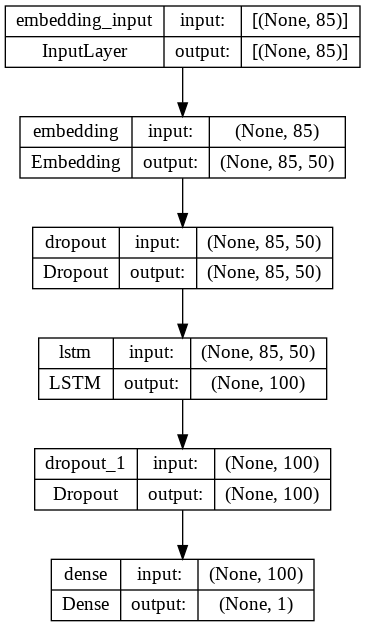

In [32]:
from keras.utils import plot_model
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [33]:
X_train.shape,y_train.shape

((937, 85), (937,))

In [34]:
X_test.shape,y_test.shape

((248, 85), (248,))

In [35]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
15/15 [==============================] - 8s 48ms/step - loss: 0.4611 - accuracy: 0.8954 - val_loss: 0.1796 - val_accuracy: 0.9597
Epoch 2/10
15/15 [==============================] - 0s 15ms/step - loss: 0.2135 - accuracy: 0.9498 - val_loss: 0.1739 - val_accuracy: 0.9597
Epoch 3/10
15/15 [==============================] - 0s 13ms/step - loss: 0.2065 - accuracy: 0.9498 - val_loss: 0.1698 - val_accuracy: 0.9597
Epoch 4/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2008 - accuracy: 0.9498 - val_loss: 0.1695 - val_accuracy: 0.9597
Epoch 5/10
15/15 [==============================] - 0s 14ms/step - loss: 0.2006 - accuracy: 0.9498 - val_loss: 0.1702 - val_accuracy: 0.9597
Epoch 6/10
15/15 [==============================] - 0s 13ms/step - loss: 0.2050 - accuracy: 0.9498 - val_loss: 0.1711 - val_accuracy: 0.9597
Epoch 7/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2029 - accuracy: 0.9498 - val_loss: 0.1691 - val_accuracy: 0.9597
Epoch 8/10
15

In [36]:
y_pred=model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


In [37]:
y_pred=np.where(y_pred > 0.6, 1,0) 

In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_test,y_pred)

array([[238,   0],
       [ 10,   0]])

# Metrics Used


*   Accuracy
*   Precision 
*   Recall
*   ROC - AUC Curve





In [40]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)  # Accuracy of 95% , but the dataset is heavily biased towards negative reviews hence accuracy not a good measure

0.9596774193548387

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))  # Precision and Recall towards class 0 ( Negative) is high but poor fot class 1

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       238
         1.0       0.00      0.00      0.00        10

    accuracy                           0.96       248
   macro avg       0.48      0.50      0.49       248
weighted avg       0.92      0.96      0.94       248



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


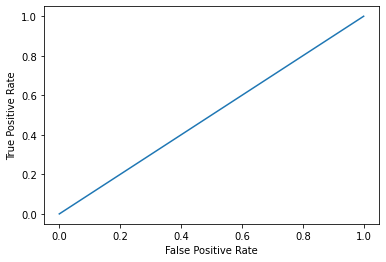

In [42]:
from sklearn import metrics  # AUC is 0.5 which means that the predictions are very random
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
import matplotlib.pyplot as plt
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model 2 - Vary the knowledge representation.

##### Using Word2Vec for embedding layer

In [56]:
from keras.preprocessing.text import Tokenizer
vocab_size = 5000
max_length = 100 #Because we are using a GLOVE Model of 100 dimensions vector
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_corpus)

In [57]:
#mapping of the words to numbers.
word_index = tokenizer.word_index

In [45]:
word_index

{'<OOV>': 1,
 'deforest': 2,
 'forest': 3,
 'amp': 4,
 'tree': 5,
 'climat': 6,
 'wildlif': 7,
 'amazon': 8,
 'plant': 9,
 'chang': 10,
 'protect': 11,
 'world': 12,
 'help': 13,
 'sustain': 14,
 'year': 15,
 'natur': 16,
 'peopl': 17,
 'land': 18,
 'product': 19,
 'use': 20,
 'anim': 21,
 'us': 22,
 'oil': 23,
 'stop': 24,
 'caus': 25,
 'global': 26,
 'environ': 27,
 'worldwildlifeday': 28,
 'one': 29,
 'new': 30,
 'human': 31,
 'support': 32,
 'palm': 33,
 'biodivers': 34,
 'indigen': 35,
 'eu': 36,
 'make': 37,
 'earth': 38,
 'save': 39,
 'loss': 40,
 'palmoil': 41,
 'learn': 42,
 'planet': 43,
 'area': 44,
 'brazil': 45,
 'habitat': 46,
 'read': 47,
 'due': 48,
 'speci': 49,
 'govern': 50,
 'agricultur': 51,
 'live': 52,
 'chain': 53,
 'today': 54,
 'reduc': 55,
 'rainforest': 56,
 'indonesia': 57,
 'end': 58,
 'soy': 59,
 'need': 60,
 'day': 61,
 'destroy': 62,
 'meat': 63,
 'fight': 64,
 'group': 65,
 'endang': 66,
 'environment': 67,
 'say': 68,
 'compani': 69,
 'link': 70,
 'cu

In [70]:
X_train_sequences = tokenizer.texts_to_sequences(train_corpus)
X_test_sequences = tokenizer.texts_to_sequences(test_corpus)

In [71]:
X_train_padded=pad_sequences(X_train_sequences,maxlen=max_length, padding="post")
X_test_padded=pad_sequences(X_test_sequences,padding='post',maxlen=max_length)

# Using GloVe word embeddings

# Steps to implement a pretrained model on your dataset
1. The first step is to obtain the word embedding and append them to a 
    dictionary. 
2. After that, you'll need to create an embedding matrix for each word in the training set.

In [48]:
!wget --no-check-certificate \
     http://nlp.stanford.edu/data/glove.6B.zip \
     -O /tmp/glove.6B.zip

--2022-12-06 04:45:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-06 04:45:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-06 04:45:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’


In [49]:
#Extract the GloVe word embeddings into a temporary folder.
import os
import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

In [50]:
# Create that dictionary with those embeddings
import numpy as np
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')  #100 means that it is the size of the window and hence the dimension of the feature vectors
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Create a word embedding matrix for each word in the word index that you obtained earlier. 
If a word doesn't have an embedding in GloVe it will be presented with a zero matrix.

In [72]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in tqdm.tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 4715/4715 [00:00<00:00, 283467.98it/s]


In [73]:
from tensorflow.keras.layers import Dropout
## Creating model
model=Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [74]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          471600    
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 552,101
Trainable params: 80,501
Non-trainable params: 471,600
_________________________________________________________________
None


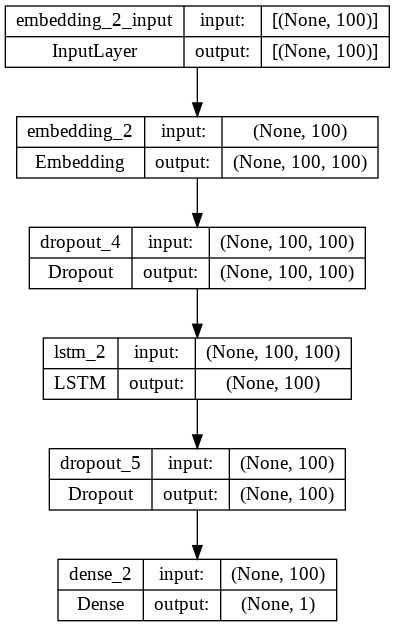

In [75]:
from keras.utils import plot_model
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [76]:
X_train_padded.shape,y_train.shape

((937, 100), (937,))

In [77]:
X_test_padded.shape,y_test.shape

((248, 100), (248,))

In [78]:
### Finally Training
model.fit(X_train_padded, y_train,validation_data=(X_test_padded,y_test),epochs=10,batch_size=64)

Epoch 1/10
15/15 [==============================] - 2s 45ms/step - loss: 0.5209 - accuracy: 0.9413 - val_loss: 0.1958 - val_accuracy: 0.9597
Epoch 2/10
15/15 [==============================] - 0s 16ms/step - loss: 0.2176 - accuracy: 0.9498 - val_loss: 0.1745 - val_accuracy: 0.9597
Epoch 3/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2073 - accuracy: 0.9498 - val_loss: 0.1725 - val_accuracy: 0.9597
Epoch 4/10
15/15 [==============================] - 0s 12ms/step - loss: 0.1998 - accuracy: 0.9498 - val_loss: 0.1690 - val_accuracy: 0.9597
Epoch 5/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2034 - accuracy: 0.9498 - val_loss: 0.1696 - val_accuracy: 0.9597
Epoch 6/10
15/15 [==============================] - 0s 12ms/step - loss: 0.2052 - accuracy: 0.9498 - val_loss: 0.1701 - val_accuracy: 0.9597
Epoch 7/10
15/15 [==============================] - 0s 13ms/step - loss: 0.2032 - accuracy: 0.9498 - val_loss: 0.1706 - val_accuracy: 0.9597
Epoch 8/10
15

In [81]:
y_pred=model.predict(X_test_padded)
y_pred=np.where(y_pred > 0.6, 1,0) 
confusion_matrix(y_test,y_pred)

8/8 [==============================] - 0s 4ms/step


array([[238,   0],
       [ 10,   0]])

In [82]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)  # Accuracy of 95% , but the dataset is heavily biased towards negative reviews hence accuracy not a good measure

0.9596774193548387

In [83]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))  # Precision and Recall towards class 0 ( Negative) is high but poor fot class 1

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       238
         1.0       0.00      0.00      0.00        10

    accuracy                           0.96       248
   macro avg       0.48      0.50      0.49       248
weighted avg       0.92      0.96      0.94       248



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


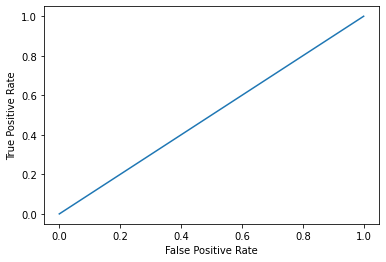

In [84]:
from sklearn import metrics  # AUC is 0.5 which means that the predictions are very random
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
import matplotlib.pyplot as plt
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Model 3 - Create a probabilistic baseline (Using Naive Bayes)

## ASSUMPTIONS

# 1. Independence assumption
In sentence "It is too hot in the sunny climate of the desert" , here you can see the word sunny and hot tend to depend on each other and are correlated to a certain extent with the word “desert”. Naive Bayes assumes independence throughout. Furthermore, if you were to fill in the sentence on the right, this naive model will assign equal weight to the words “spring, summer, fall, winter”.

# 2. Relative frequencies
On Twitter, there are usually more positive tweets than negative ones. However, some “clean” datasets you may find are artificially balanced to have the same amount of positive and negative tweets. Just keep in mind, that in the real world, the data could be much noisier.

### Preprocessing the tweets dataset

In [109]:
def process_tweet(tweet):
    
    #Remove hyperlinks
    tweet2 = re.sub(r'https?:\/\/.*[\r\n]*','', tweet)
    
    #Remove hastags
    #Only removing the hash # sign from the word
    tweet2 = re.sub(r'#','',tweet2)
        
    # instantiate tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False,    strip_handles=True, reduce_len=True)
    
    # tokenize tweets
    tweet_tokens = tokenizer.tokenize(tweet2)    
        
    #Import the english stop words list from NLTK
    stopwords_english = stopwords.words('english') 
    
    #Creating a list of words without stopwords
    tweets_clean = []
    for word in tweet_tokens:
        if word not in stopwords_english and word not in string.punctuation:
            tweets_clean.append(word)
        
    #Instantiate stemming class
    stemmer = PorterStemmer()
    
    #Creating a list of stems of words in tweet
    tweets_stem = []
    for word in tweets_clean:
        stem_word = stemmer.stem(word)
        tweets_stem.append(stem_word)
        
    return tweets_stem

#### A function that will take tweets and their labels as input, go through every tweet, preprocess them, count the occurrence of every word in the data set and create a frequency dictionary

In [110]:
#Frequency generating function
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
            
    return freqs

tweets=df["text"].tolist()+test_dataset["text"].tolist()
ys=y_test.tolist()+y_train.tolist()
freqs=build_freqs(tweets,ys)

Naive Bayes algorithm is based on the Bayes rule, which can be represented as follows:

**P(X∣Y)=P(Y)P(Y∣X)P(X)​**

Here, the process up to creating a dictionary of frequencies (importing libraries, preprocessing, etc.) is the same. The way the algorithm works is as follows:-

1. Find the log of the ratio of the number of positive tweets and negative sentiment tweets.
        logprior = log(𝑃(𝐷𝑝𝑜𝑠))−log(𝑃(𝐷𝑛𝑒𝑔))=log(𝐷𝑝𝑜𝑠)−log(𝐷𝑛𝑒𝑔)

2. Instead of keeping the frequencies of each word with the positive and negative labels we take the ratio of their frequency in that label by the total number of frequencies in that label. This will give the probability of occurrence of that word given the tweet is positive/negative.

3. Then we make another property called loglikelihood. It is the log of the ratio of Positive probability to that of the negative probability of a particular word. But what if the probability of the word is zero ( frequency is zero in either positive or negative case) the log may become +/- infinity. Hence to overcome this we use additive smoothing. This wiki article explains more about additive smoothing.

4. Therefore, to compute the positive probability and the negative probability for a specific word in the vocabulary, we’ll use the following inputs:

𝑓𝑟𝑒𝑞𝑝𝑜𝑠 and 𝑓𝑟𝑒𝑞𝑛𝑒𝑔 are the frequencies of that specific word in 
the positive or negative class. In other words, the positive frequency of a word is the number of times the word is counted with the label of 1.

𝑁𝑝𝑜𝑠 and 𝑁𝑛𝑒𝑔 are the total numbers of positive and negative words for all documents (for all tweets), respectively.
𝑉 is the number of unique words in the entire set of documents, for all classes, whether positive or negative.

We’ll use these to compute the positive and negative probability for a specific word using this formula:

    𝑃(𝑊𝑝𝑜𝑠)= (𝑓𝑟𝑒𝑞𝑝𝑜𝑠+1)/(𝑁𝑝𝑜𝑠+𝑉)

    𝑃(𝑊𝑛𝑒𝑔)= (𝑓𝑟𝑒𝑞𝑛𝑒𝑔+1)/(𝑁𝑛𝑒𝑔+𝑉)

Notice that we add the “+1” in the numerator for additive smoothing.

And the loglikelihood can be represented as:-

    loglikelihood=log(𝑃(𝑊𝑝𝑜𝑠)/𝑃(𝑊𝑛𝑒𝑔))




#### We just need to code the above written in order to train our Naive Bayes function

In [116]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0
    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)
    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:
            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs.get(pair, 1)
        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs.get(pair, 1)
    # Calculate D, the number of documents
    D = len(train_y)
    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = sum(train_y)
    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = D-D_pos
    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = freqs.get((word, 1),0)
        freq_neg = freqs.get((word, 0),0)
        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(N_pos + V)
        p_w_neg = (freq_neg + 1)/(N_neg + V)
        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)
    return logprior, loglikelihood
logprior, loglikelihood = train_naive_bayes(freqs, train_corpus, y_train)

#### In order to predict the sentiment of a tweet we simply have to sum up the loglikelihood of the words in the tweet along with the logprior. If the value is positive then the tweet shows positive sentiment but if the value is negative then the tweet shows negative sentiment.

In [123]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)
'''
    # process the tweet to get a list of words
    word_l = process_tweet(tweet)
# initialize probability to zero
    p = 0
# add the logprior
    p += logprior
    for word in word_l:
    # check if the word exists in the loglikelihood dictionary
            if word in loglikelihood:
                # add the log likelihood of that word to the probability
                p += loglikelihood[word]
    return p

def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  # return this properly
    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0
# append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    
    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats - test_y))
# Accuracy is 1 minus the error
    accuracy = 1 - error
    return accuracy

In [124]:
test_naive_bayes(test_corpus, y_test, logprior, loglikelihood)  #We get an accurace of 94 percent here

0.9435483870967742